In [1]:
import matplotlib
from intervaltree import IntervalTree, Interval
from matplotlib.patches import Rectangle
import re
import seaborn as sns
import collections
class region_gene_plot():
    """
    edited from https://github.com/deeptools/pyGenomeTracks
    """
    def __init__(self, chrom, start, end, gene_anno_df, ax, properties={'fontsize':9, 'color':["#b7704f", "#417ca8", "#399387"], 'border color':None, 'labels':'on', 'interval_height':50, 'line width':0.5, 'display': 'collapsed', 'style':'flybase'}):
        """
        anno_hdf5 = '/home/WBXie/ricev7_GWAS/riceV7_annotation_df.h5'
        gene_anno_df = pd.read_hdf(anno_hdf5,'anno')
        anno_hdf5 = '/home/hzhao/rice_genome_sequence/MSU/version_7.0/all_DIY_bed.h5' ##with intron
        """
        from matplotlib import font_manager
        from matplotlib.colors import ListedColormap
        self.chrom = chrom
        self.start = start
        self.end = end
        self.gene_anno_df = gene_anno_df
        self.ax = ax
        self.colormap = None
        self.interval_tree = {}
        self.properties=  properties
        self.row_scale = self.properties['interval_height'] * 1.2
        self.fp = font_manager.FontProperties(size=self.properties['fontsize'])
        if 'block_count' not in gene_anno_df.columns:
            self.fields = ['chromosome', 'start', 'end','strand','name', 'score']
            self.properties['style'] = 'simple'
        else:
            self.fields = ['chromosome', 'start', 'end','name', 'score', 'strand','thick_start', 'thick_end','rgb', 'block_count', 'block_sizes', 'block_starts']
        self.BedInterval = collections.namedtuple('BedInterval', self.fields)
        if self.colormap is None:
            cmap = ListedColormap(sns.color_palette(self.properties['color']).as_hex())
            #cmap = matplotlib.cm.get_cmap(self.properties['color'])
            self.colormap = cmap
    def get_length_w(self, fig_width, region_start, region_end):
        '''
        to improve the visualization of the genes it is good to have an estimation of the label
        length. In the following code I try to get the length of a 'W' in base pairs.
        '''
        if self.properties['labels'] == 'on':
            # from http://scipy-cookbook.readthedocs.org/items/Matplotlib_LaTeX_Examples.html
            inches_per_pt = 1.0 / 72.27
            font_in_inches = self.properties['fontsize'] * inches_per_pt
            region_len = region_end - region_start
            bp_per_inch = region_len / fig_width
            font_in_bp = font_in_inches * bp_per_inch
            self.len_w = font_in_bp
        else:
            self.len_w = 0.5

        return self.len_w
    def get_max_num_row(self, len_w, small_relative):
        ''' Process the whole bed regions at the given figure length and font size to
        determine the maximum number of rows required.
        :return:
        '''

        self.max_num_row = {}
        for chrom in self.interval_tree:
            row_last_position = []  # each entry in this list contains the end position
            self.max_num_row[chrom] = 0
            for region in sorted(self.interval_tree[chrom][0:500000000]):
                bed = region.data
                #ipdb.sset_trace()
                if self.properties['labels'] == 'on':
                    bed_extended_end = int(bed.end + (len(bed.name) * len_w))
                else:
                    bed_extended_end = (bed.end + 2 * small_relative)

                # get smallest free row
                if len(row_last_position) == 0:
                    free_row = 0
                    row_last_position.append(bed_extended_end)
                else:
                    # get list of rows that are less than bed.start, then take the min
                    idx_list = [idx for idx, value in enumerate(row_last_position) if value < bed.start]
                    if len(idx_list):
                        free_row = min(idx_list)
                        row_last_position[free_row] = bed_extended_end
                    else:
                        free_row = len(row_last_position)
                        row_last_position.append(bed_extended_end)

                if free_row > self.max_num_row[bed.chromosome]:
                    self.max_num_row[bed.chromosome] = free_row

        #self.log.debug("max number of rows set to {}".format(self.max_num_row))
        return self.max_num_row
    def get_y_pos(self, free_row):
        """
        The y_pos is set such that regions to be plotted do not overlap (stacked). To override this
        the properties['collapsed'] needs to be set.
        The algorithm uses a interval tree (self.region_interval) to check the overlaps
        and a sort of coverage vector 'rows used' to identify the row in which to plot
        :return: int y position
        """

        # if the domain directive is given, ypos simply oscilates between 0 and 100
        if self.properties['display'] == 'interlaced':
            ypos = self.properties['interval_height'] if self.counter % 2 == 0 else 1

        elif self.properties['display'] == 'collapsed':
            ypos = 0

        else:
            ypos = free_row * self.row_scale
        return ypos


    def get_rgb_and_edge_color(self, bed):
        rgb = self.properties['color']
        edgecolor = self.properties['border color']
        #ipdb.sset_trace()
        if self.colormap:
            # translate value field (in the example above is 0 or 0.2686...) into a color
            rgb = self.colormap(bed.score)
            self.rgb = rgb
        if self.properties['color'] == 'bed_rgb':
            if self.bed_type in ['bed9', 'bed12'] and len(bed.rgb) == 3:
                try:
                    rgb = [float(x) / 255 for x in bed.rgb]
                    if 'border color' in self.properties:
                        edgecolor = self.properties['border color']
                    else:
                        edgecolor = self.properties['color']
                except IndexError:
                    rgb = DEFAULT_BED_COLOR
            else:
                rgb = DEFAULT_BED_COLOR
        return rgb, edgecolor

    def gene_plot(self):
        n = 0
        #ipdb.sset_trace()
        if self.properties['style'] == 'flybase':
            gene_anno_df = self.gene_anno_df[(self.gene_anno_df.chromosome == self.chrom) & (self.gene_anno_df.start >= self.start) & (self.gene_anno_df.end <= self.end)]
            gene_data = []
            for i,g in gene_anno_df.iterrows():
                #ipdb.sset_trace()
                gene_data.append( self.BedInterval._make([g.chromosome, g.start, g.end, g['name'], n%3, g.strand, g.thick_start, g.thick_end, g.rgb, g.block_count, list(map(int,re.split(',',g.block_sizes)[:-1])), list(map(int,re.split(',',g.block_starts)[:-1]))]))
                n+=1
        else:
            gene_anno_df = self.gene_anno_df[(self.gene_anno_df.chrom == self.chrom) & (self.gene_anno_df.gene_start >= self.start) & (self.gene_anno_df.gene_end <= self.end)]
            gene_data = []
            for i,g in gene_anno_df.iterrows():
                gene_data.append( self.BedInterval._make([g.chrom, g.gene_start, g.gene_end, g.strand, i, n%3]))
                n +=1
        #ipdb.sset_trace()
        interval_tree = {}
        for bed in gene_data:
            if bed.chromosome not in interval_tree:
                interval_tree[bed.chromosome] = IntervalTree()
            interval_tree[bed.chromosome].add(Interval(bed.start, bed.end, bed))
        self.interval_tree = interval_tree
        self.counter = 0
        self.small_relative = 0.04 * (self.end - self.start)
        self.get_length_w(self.ax.get_figure().get_figwidth(), self.start, self.end)
        self.get_max_num_row(self.len_w, self.small_relative)
        genes_overlap = sorted(self.interval_tree[self.chrom][self.start:self.end])
        if self.properties['labels'] != 'off' and len(genes_overlap) > 60:
            self.properties['labels'] = 'off'
        linewidth = self.properties['line width']
        max_num_row_local = 1
        max_ypos = 0
        row_last_position = []
        #ipdb.sset_trace()
        for region in genes_overlap:
            self.counter += 1
            bed = region.data
            if self.properties['labels'] == 'on':
                num_name_characters = len(bed.name) + 2
                bed_extended_end = int(bed.end + (num_name_characters * self.len_w))
            else:
                bed_extended_end = (bed.end + 2 * self.small_relative)
            if len(row_last_position) == 0:
                free_row = 0
                row_last_position.append(bed_extended_end)
            else:
                idx_list = [idx for idx, value in enumerate(row_last_position) if value < bed.start]
                if len(idx_list):
                    free_row = min(idx_list)
                    row_last_position[free_row] = bed_extended_end
                else:
                    free_row = len(row_last_position)
                    row_last_position.append(bed_extended_end)
            rgb, edgecolor = self.get_rgb_and_edge_color(bed)
            ypos = self.get_y_pos(free_row)
            if 'gene rows' in self.properties and free_row >= int(self.properties['gene rows']):
                continue
            if free_row > max_num_row_local:
                max_num_row_local = free_row
            if ypos > max_ypos:
                max_ypos = ypos
            if self.properties['style'] == 'flybase':
                self.draw_gene_with_introns_flybase_style(bed, ypos, rgb, edgecolor, linewidth)
            else:
                self.draw_gene_simple(bed, ypos, rgb, edgecolor, linewidth)
            if self.properties['labels'] == 'off':
                pass
            elif bed.start > self.start and bed.end < self.end:
                #ipdb.sset_trace()
                self.ax.text(bed.end + self.small_relative, ypos + (float(self.properties['interval_height']) / 2),
                        bed.name, horizontalalignment='left',
                        verticalalignment='center', fontproperties=self.fp)
            ymin = 0
            #ipdb.sset_trace()
            if 'global max row' in self.properties and self.properties['global max row'] == 'yes':
                ymax = self.max_num_row[self.chrom] * self.row_scale
            elif 'gene rows' in self.properties:
                ymax = int(self.properties['gene rows']) * self.row_scale
            else:
                ymax = max_ypos + self.properties['interval_height']
            #self.log.debug("ylim {},{}".format(ymin, ymax))
            #self.ax.set_ylim(ymin, ymax)
            #if 'display' in self.properties:
            #    if self.properties['display'] == 'domain':
            #        self.ax.set_ylim(-5, 205)
            #    elif self.properties['display'] == 'collapsed':
            #        self.ax.set_ylim(-5, 105)
        self.ax.set_ylim(ymin-self.properties['interval_height']*0.2, ymax+self.properties['interval_height']*0.2)
        self.ax.set_xlim(self.start, self.end)
        return [self.start, self.end, self.max_num_row]

    def plot_label(self, label_ax):
        label_ax.text(0.05, 1, self.properties['title'],
                      horizontalalignment='left', size='large',
                      verticalalignment='top', transform=label_ax.transAxes)
    def draw_gene_simple(self, bed, ypos, rgb, edgecolor, linewidth):
        """
        draws an interval with direction (if given)
        """
        from matplotlib.patches import Polygon
        #ipdb.sset_trace()
        if bed.strand not in ['+', '-']:
            self.ax.add_patch(Rectangle((bed.start, ypos), bed.end - bed.start, self.properties['interval_height'],
                                   edgecolor=edgecolor, facecolor=rgb, linewidth=linewidth))
        else:
            vertices = self._draw_arrow(bed.start, bed.end, bed.strand, ypos)
            self.ax.add_patch(Polygon(vertices, closed=True, fill=True,
                                 edgecolor=edgecolor,
                                 facecolor=rgb,
                                 linewidth=linewidth))
    def _draw_arrow(self, start, end, strand, ypos):
        """
        Draws a filled arrow
        :param start:
        :param end:
        :param strand:
        :param ypos:
        :return: None
        """
        half_height = float(self.properties['interval_height']) / 2
        if strand == '+':
            x0 = start
            x1 = end  # - self.small_relative
            y0 = ypos
            y1 = ypos + float(self.properties['interval_height'])
            """
            The vertices correspond to 5 points along the path of a form like the following,
            starting in the lower left corner and progressing in a clock wise manner.
            -----------------\
            ---------------- /
            """

            vertices = [(x0, y0), (x0, y1), (x1, y1), (x1 + self.small_relative, y0 + half_height), (x1, y0)]

        else:
            x0 = start  # + self.small_relative
            x1 = end
            y0 = ypos
            y1 = ypos + self.properties['interval_height']
            """
            The vertices correspond to 5 points along the path of a form like the following,
            starting in the lower left corner and progressing in a clock wise manner.
            /-----------------
            \-----------------
            """
            vertices = [(x0, y0), (x0 - self.small_relative, y0 + half_height), (x0, y1), (x1, y1), (x1, y0)]

        return vertices
    def draw_gene_with_introns_flybase_style(self, bed, ypos, rgb, edgecolor, linewidth):
        """
        draws a gene using different styles
        """
        from matplotlib.patches import Polygon
        if bed.block_count == 0 and bed.thick_start == bed.start and bed.thick_end == bed.end:
            self.draw_gene_simple(ax, bed, ypos, rgb, edgecolor)
            return
        half_height = float(self.properties['interval_height']) / 2
        # draw 'backbone', a line from the start until the end of the gene
        self.ax.plot([bed.start, bed.end], [ypos + half_height, ypos + half_height], 'black',
                linewidth=linewidth, zorder=-1)

        # get start, end of all the blocks
        positions = []
        #ipdb.sset_trace()

        for idx in range(0, bed.block_count):
            x0 = bed.start + bed.block_starts[idx]
            x1 = x0 + bed.block_sizes[idx]
            if x0 < bed.thick_start < x1:
                positions.append((x0, bed.thick_start, 'UTR'))
                positions.append((bed.thick_start, x1, 'coding'))

            elif x0 < bed.thick_end < x1:
                positions.append((x0, bed.thick_end, 'coding'))
                positions.append((bed.thick_end, x1, 'UTR'))

            else:
                if x1 < bed.thick_start or x0 > bed.thick_end:
                    type = 'UTR'
                else:
                    type = 'coding'
                positions.append((x0, x1, type))

        # plot all blocks as rectangles except the last if the strand is + or
        # the first is the strand is -, which are drawn as arrows.
        if bed.strand == '-':
            positions = positions[::-1]

        first_pos = positions.pop()
        if first_pos[2] == 'UTR':
            _rgb = 'grey'
        else:
            _rgb = rgb

        vertices = self._draw_arrow(first_pos[0], first_pos[1], bed.strand, ypos)

        self.ax.add_patch(Polygon(vertices, closed=True, fill=True,
                             edgecolor=edgecolor,
                             facecolor=_rgb,
                             linewidth=linewidth))

        for start_pos, end_pos, _type in positions:
            if _type == 'UTR':
                _rgb = 'grey'
            else:
                _rgb = rgb
            vertices = [(start_pos, ypos), (start_pos, ypos + self.properties['interval_height']),
                        (end_pos, ypos + self.properties['interval_height']), (end_pos, ypos)]

            self.ax.add_patch(Polygon(vertices, closed=True, fill=True,
                                 edgecolor=edgecolor,
                                 facecolor=_rgb,
                                 linewidth=linewidth))

In [8]:
! pip install pyBigWig

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.5/192.5 kB 873.4 kB/s eta 0:00:00a 0:00:01


In [3]:
import warnings
warnings.filterwarnings("ignore")
from imp import reload
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import bezier
import numpy
import matplotlib
import pyBigWig
import pandas as pd
import numpy as np
import glob
import os, re
gene_anno = pd.read_table("/work/home/acc1hz5x99/zhutao/T2T/gmax.basic.annotation.sort.bed12",names=["chromosome","start", "end", "name", "score", "strand", "thick_start", "thick_end", "rgb", "block_count", "block_sizes", "block_starts"])
gene_anno['chromosome']=gene_anno['chromosome'].str.replace('Gm0', '', regex=True).str.replace('Gm', '', regex=True)

In [10]:
bin=100
chrom = "Gm01"
start = 2525800
end =  2528800
bw1 = pyBigWig.open("/work/home/acc1hz5x99/zhutao/other/mianshang/atac_out/bw_jw/CS007EM_ATAC.bw")
df_1=pd.DataFrame(bw1.values(chrom,start,end),columns=['cut_num'])
df_1.head()

,cut_num
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


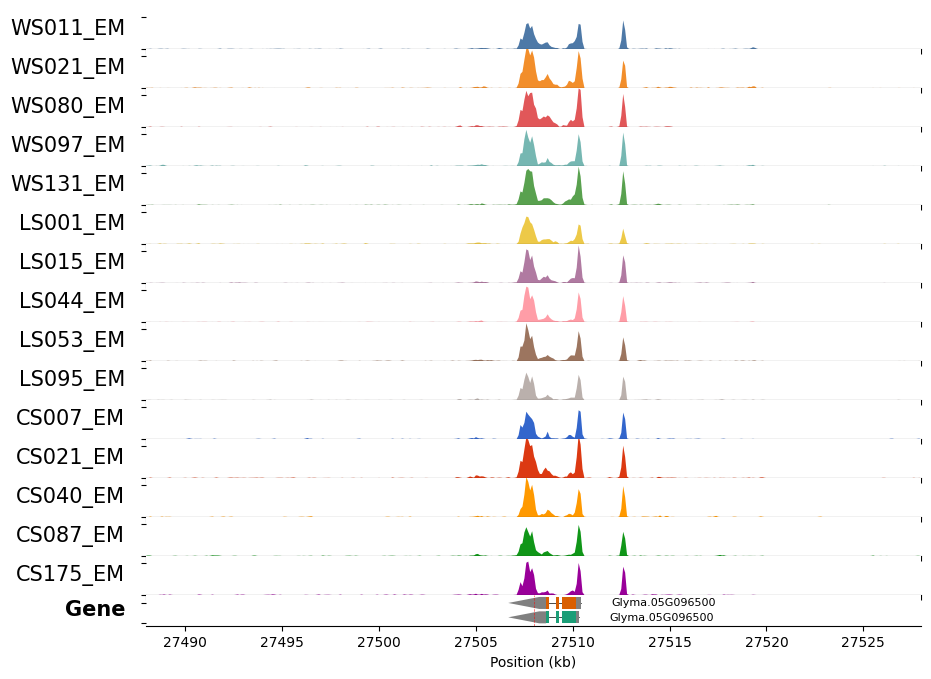

In [6]:
import warnings
warnings.filterwarnings("ignore")
from imp import reload
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import bezier
import numpy
import matplotlib
import pyBigWig
import pandas as pd
import numpy as np
import glob
import os, re

## read bw file
pad =15
bin=100  #Gm07_13136341_13136366  Gm01_54233619_54233647 Gm05_27507984_27508013
CHROM = "Gm05"
start = 27507984 - 20000
end =  27507984 + 20000
lst = []
tissue_file = pd.read_table("/work/home/acc1hz5x99/zhutao/other/mianshang/pipeline/signal/name.txt",names=['tissue'])
for tissue in tissue_file['tissue']:
    bw = pyBigWig.open("/work/home/acc1hz5x99/zhutao/other/mianshang/pipeline/signal/%s.cpm.bw"%tissue)
    df_1=pd.DataFrame(bw.values(CHROM,start,end),columns=['cut_num'])
    df1=df_1.groupby(np.arange(len(df_1))//bin).mean()
    lst.append(df1)

## Set tracks color
color_f = pd.read_table("/work/home/acc1hz5x99/zhutao/other/mianshang/pipeline/signal/color.txt",names=['tissue','color'])
zip_iterator = zip(color_f['tissue'], color_f['color'])
color_dict = dict(zip_iterator)
## read peak file
#peak = pd.read_table("/public/workspace/zhutao/encode/figure/fig3/bw/nip_mh_zs_peak_type.csv",names=['chr','start','end','state','type'])

f, ax=plt.subplots(16,1,figsize=(10, 8),gridspec_kw = {'height_ratios': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.8]},squeeze=False)
gene_anno = pd.read_table("/work/home/acc1hz5x99/zhutao/T2T/gmax.basic.annotation.sort.bed12",names=["chromosome","start", "end", "name", "score", "strand", "thick_start", "thick_end", "rgb", "block_count", "block_sizes", "block_starts"])
#gene_anno['chromosome']=gene_anno['chromosome'].str.replace('Gm0', '', regex=True).str.replace('Gm', '', regex=True)
genes = region_gene_plot(CHROM, start, end, gene_anno, ax=ax[15][0],properties={'fontsize':8, 'color':'Dark2', 'border color':None, 'labels':'on', 'interval_height':30, 'line width':0.5, 'display': 'stacked', 'style':'flybase'})
ax[15][0].annotate('Gene', xy=(0, 0.5), xytext=(-pad, 0), xycoords="axes fraction",textcoords='offset points',ha='right', va='center',weight='bold',fontsize=15)
my_start, my_end, row = genes.gene_plot()

plt.subplots_adjust(hspace=0.2)
ax[15][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y /1000)))
ax[15][0].set_xlabel('Position (kb)')
ax[15][0].set_yticklabels([])
ax[15][0].axvline(x=27507984, color='red', linestyle='--', linewidth=0.5, alpha=0.7)
#ax[15][0].axvline(x=23058674, color='red', linestyle='--', linewidth=0.5, alpha=0.7)

# peak_plot = peak[(peak['chr']==chrom) & (peak['start']>=start) & (peak['end']<=end)]
# for peak_id in range(0,len(peak_plot)):
#     ax[23][0].plot([int(list(peak_plot.iloc[peak_id,])[1]), int(list(peak_plot.iloc[peak_id,])[2])],[1,1],linewidth=5,linestyle ='-',solid_capstyle='butt',color="#0072B5")
# ax[23][0].set_ylabel('')
# ax[23][0].set_xlabel('')
# ax[23][0].set_xticklabels([])
# ax[23][0].set_yticklabels([])
# ax[23][0].set_xlim([start, end])
# ax[23][0].annotate('Peaks', xy=(0, 0.5), xytext=(-pad, 0), xycoords="axes fraction",textcoords='offset points',ha='right', va='center',weight='bold',fontsize=15)

    ##Set y max value
max_value = []
for i,d in enumerate(lst):
    max_value.append(max(d['cut_num']))
    ## Plot tracks
for i,d in enumerate(lst):
    g=d.plot.area(legend=False,stacked=False,ax=ax[i][0],alpha=1,color=color_dict.get(tissue_file['tissue'][i]),linewidth=0)
    ax[i][0].set_ylabel('')
    ax[i][0].set_xlabel('')
    ax[i][0].set_xticklabels([])
    ax[i][0].set_yticklabels([])
    ax[i][0].set_xlim([0, len(d)])
    ax[i][0].set_ylim([0, 0.9*max(max_value)])
    
    # 添加两条垂直虚线
    
    ax[i][0].annotate(tissue_file['tissue'][i], xy=(0, 0.5), xytext=(-pad, 0), xycoords="axes fraction",textcoords='offset points',ha='right', va='center',fontsize=15)
    g=plt.subplots_adjust(hspace = .001)
sns.despine(left=True)
#plt.savefig("./EM.pdf")
#ax[0][0].set_title(gene)

In [ ]:
# Gm07    13136318        13136655
#         13136341        13136366

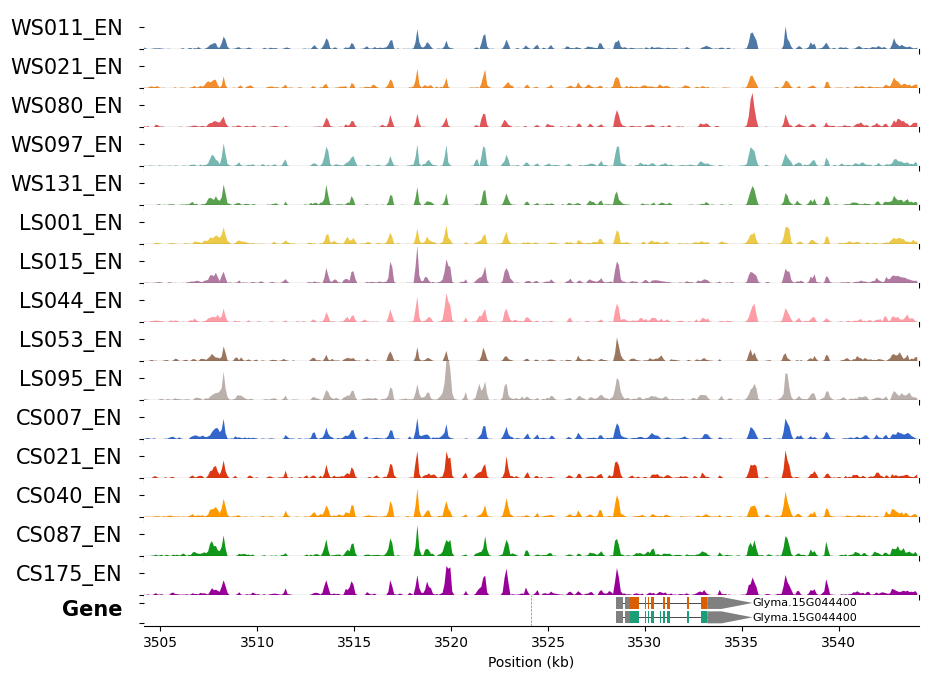

In [4]:
## read bw file
pad =15
bin=100
CHROM = "Gm15"
start = 3524134 - 20000
end =  3524134 + 20000
lst = []
tissue_file = pd.read_table("/work/home/acc1hz5x99/zhutao/other/mianshang/pipeline/signal/name.txt1",names=['tissue'])
for tissue in tissue_file['tissue']:
    bw = pyBigWig.open("/work/home/acc1hz5x99/zhutao/other/mianshang/pipeline/signal/%s.cpm.bw"%tissue)
    df_1=pd.DataFrame(bw.values(CHROM,start,end),columns=['cut_num'])
    df1=df_1.groupby(np.arange(len(df_1))//bin).mean()
    lst.append(df1)

## Set tracks color
color_f = pd.read_table("/work/home/acc1hz5x99/zhutao/other/mianshang/pipeline/signal/color.txt1",names=['tissue','color'])
zip_iterator = zip(color_f['tissue'], color_f['color'])
color_dict = dict(zip_iterator)
## read peak file
#peak = pd.read_table("/public/workspace/zhutao/encode/figure/fig3/bw/nip_mh_zs_peak_type.csv",names=['chr','start','end','state','type'])

f, ax=plt.subplots(16,1,figsize=(10, 8),gridspec_kw = {'height_ratios': [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0.8]},squeeze=False)
gene_anno = pd.read_table("/work/home/acc1hz5x99/zhutao/T2T/gmax.basic.annotation.sort.bed12",names=["chromosome","start", "end", "name", "score", "strand", "thick_start", "thick_end", "rgb", "block_count", "block_sizes", "block_starts"])
#gene_anno['chromosome']=gene_anno['chromosome'].str.replace('Gm0', '', regex=True).str.replace('Gm', '', regex=True)
genes = region_gene_plot(CHROM, start, end, gene_anno, ax=ax[15][0],properties={'fontsize':8, 'color':'Dark2', 'border color':None, 'labels':'on', 'interval_height':30, 'line width':0.5, 'display': 'stacked', 'style':'flybase'})
ax[15][0].annotate('Gene', xy=(0, 0.5), xytext=(-pad, 0), xycoords="axes fraction",textcoords='offset points',ha='right', va='center',weight='bold',fontsize=15)
my_start, my_end, row = genes.gene_plot()

plt.subplots_adjust(hspace=0.2)
ax[15][0].xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y /1000)))
ax[15][0].set_xlabel('Position (kb)')
ax[15][0].set_yticklabels([])
ax[15][0].axvline(x=3524134, color='red', linestyle='--', linewidth=0.5, alpha=0.7)

# peak_plot = peak[(peak['chr']==chrom) & (peak['start']>=start) & (peak['end']<=end)]
# for peak_id in range(0,len(peak_plot)):
#     ax[23][0].plot([int(list(peak_plot.iloc[peak_id,])[1]), int(list(peak_plot.iloc[peak_id,])[2])],[1,1],linewidth=5,linestyle ='-',solid_capstyle='butt',color="#0072B5")
# ax[23][0].set_ylabel('')
# ax[23][0].set_xlabel('')
# ax[23][0].set_xticklabels([])
# ax[23][0].set_yticklabels([])
# ax[23][0].set_xlim([start, end])
# ax[23][0].annotate('Peaks', xy=(0, 0.5), xytext=(-pad, 0), xycoords="axes fraction",textcoords='offset points',ha='right', va='center',weight='bold',fontsize=15)

    ##Set y max value
max_value = []
for i,d in enumerate(lst):
    max_value.append(max(d['cut_num']))
    ## Plot tracks
for i,d in enumerate(lst):
    g=d.plot.area(legend=False,stacked=False,ax=ax[i][0],alpha=1,color=color_dict.get(tissue_file['tissue'][i]),linewidth=0)
    ax[i][0].set_ylabel('')
    ax[i][0].set_xlabel('')
    ax[i][0].set_xticklabels([])
    ax[i][0].set_yticklabels([])
    ax[i][0].set_xlim([0, len(d)])
    ax[i][0].set_ylim([0, 0.9*max(max_value)])
    ax[i][0].annotate(tissue_file['tissue'][i], xy=(0, 0.5), xytext=(-pad, 0), xycoords="axes fraction",textcoords='offset points',ha='right', va='center',fontsize=15)
    g=plt.subplots_adjust(hspace = .001)              
    #plt.tight_layout()
    #plt.subplots_adjust(hspace=0.2)
sns.despine(left=True)
#plt.savefig("./EN.pdf")
#ax[0][0].set_title(gene)